In [1]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import easydict
import pandas as pd
import util
from efficientnet_pytorch import EfficientNet
from torchvision import transforms

In [2]:
util.seed_everything(777)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print('Device : {}'.format(device))

args = easydict.EasyDict({
    "device": device,
    "model": "efficientnet-b7",
    "model_weight": "./save/02091550/model_best.pth.tar", 

    "train_data_file_dir": "./data/dirty_mnist_2nd/",
    "test_data_file_dir": "./data/test_dirty_mnist_2nd/",

    "train_data_answer_dir": "./data/dirty_mnist_2nd_answer.csv",
    "submission_file_dir": "./data/sample_submission.csv",

    "batch_size": 16,
})

assert os.path.isfile(args.model_weight), 'wrong path'
assert os.path.isdir(args.train_data_file_dir), 'wrong path'
assert os.path.isdir(args.test_data_file_dir), 'wrong path'
assert os.path.isfile(args.train_data_answer_dir), 'wrong path'
assert os.path.isfile(args.submission_file_dir), 'wrong path'

model = EfficientNet.from_name(args.model, in_channels=1, num_classes=26)
model.load_state_dict(torch.load(args.model_weight))
print('weight {} is loaded'.format(args.model_weight))

train_df = pd.read_csv(args.train_data_answer_dir)

train_set = util.DatasetMNIST(
    image_folder=args.train_data_file_dir,
    label_df=train_df,
    transforms=util.mnist_transforms['valid']
)

train_data_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size = args.batch_size,
        shuffle = True,
    )

test_df = pd.read_csv(args.submission_file_dir)

test_set = util.DatasetMNIST(
    image_folder=args.test_data_file_dir,
    label_df=test_df,
    transforms=util.mnist_transforms['valid']
)

test_data_loader = torch.utils.data.DataLoader(
        test_set,
        batch_size = args.batch_size,
        shuffle = True,
    )

iterator = iter(test_data_loader)

Device : cuda:1
weight ./save/02091550/model_best.pth.tar is loaded


[]

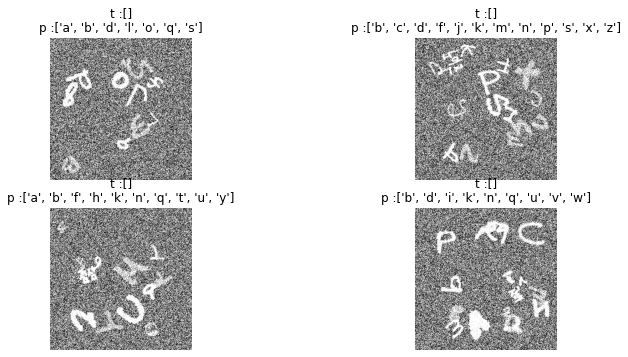

In [16]:
image, label = next(iterator)

image_t = image.float().to(args.device)

model.to(args.device)
model.eval()
pred = model(image_t)

plt.figure(figsize=(12,12))

for idx in range(4):
    plt.subplot(4, 2, idx + 1)
    
    img = transforms.ToPILImage()(image[idx])
    
    true_y = test_df.columns[1:][label[idx].detach().to('cpu').numpy() > 0.5].values.tolist()
    pred_y = test_df.columns[1:][pred[idx].detach().to('cpu').numpy() > 0.5].values.tolist()

    plt.title('t :' + str(true_y) + '\n' + 'p :' + str(pred_y))
    plt.imshow(img, 'gray')
    plt.axis('off')

plt.plot()

In [4]:
SAVE_PATH = args.model_weight.replace('model_best.pth.tar', '')

submit = pd.read_csv(args.submission_file_dir)

model.to(args.device)
model.eval()

batch_size = args.batch_size
batch_index = 0

for i, (images, targets) in enumerate(tqdm(test_data_loader)):
    images = images.to(args.device)
    # targets = targets.to(args.device)
    outputs = model(images)
    outputs = outputs > 0.0
    batch_index = i * batch_size
    submit.iloc[batch_index:batch_index+batch_size, 1:] = \
        outputs.long().squeeze(0).detach().cpu().numpy()
    
submit.to_csv(os.path.join(SAVE_PATH, args.model_weight.split('/')[2] + '_submission.csv'), index=False)
print('submission fils is saved to {}'.format(SAVE_PATH))

100%|██████████| 313/313 [00:50<00:00,  6.16it/s]submission fils is saved to ./save/02091550/

